<a href="https://colab.research.google.com/github/PotlachervuSrilatha/Bike_Sharing_Rental_Project/blob/main/Project_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries :

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import KFold , GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix as cm, accuracy_score as ac, mean_squared_error,classification_report as report,\
roc_curve, roc_auc_score , recall_score , precision_score, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OrdinalEncoder,OneHotEncoder
from sklearn.ensemble import RandomForestRegressor


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
bike=pd.read_csv("bike_rent.csv" )
bike

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2011,springer,2011,1,0,No,6,No work,Clear,0.24,0.2879,0.81,0,3,13,16
1,2,01-01-2011,springer,2011,1,1,No,6,No work,Clear,0.22,0.2727,0.8,0,8,32,40
2,3,01-01-2011,springer,2011,1,2,No,6,No work,Clear,0.22,0.2727,?,0,5,27,32
3,4,01-01-2011,springer,2011,1,3,No,6,No work,Clear,0.24,0.2879,0.75,0,3,10,13
4,5,01-01-2011,springer,2011,1,4,No,6,No work,Clear,0.24,0.2879,0.75,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,31-12-2012,springer,2012,12,19,No,1,Working Day,Mist,0.26,0.2576,0.6,0.1642,11,108,119
17375,17376,31-12-2012,springer,2012,12,20,No,1,Working Day,Mist,0.26,0.2576,0.6,0.1642,8,81,89
17376,17377,31-12-2012,springer,2012,12,21,No,1,Working Day,Clear,?,0.2576,0.6,0.1642,7,83,90
17377,17378,31-12-2012,springer,2012,12,22,No,1,Working Day,Clear,0.26,0.2727,0.56,0.1343,13,48,61


### Data Preprocessing :

#### Check for special characters in the dataset and replace it with nan :

In [ ]:

bike = bike.replace('?', np.nan) # replace all occurrences of "?" with ' ' in the DataFrame
bike.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2011,springer,2011,1,0,No,6,No work,Clear,0.24,0.2879,0.81,0,3,13,16
1,2,01-01-2011,springer,2011,1,1,No,6,No work,Clear,0.22,0.2727,0.8,0,8,32,40
2,3,01-01-2011,springer,2011,1,2,No,6,No work,Clear,0.22,0.2727,NaN,0,5,27,32
3,4,01-01-2011,springer,2011,1,3,No,6,No work,Clear,0.24,0.2879,0.75,0,3,10,13
4,5,01-01-2011,springer,2011,1,4,No,6,No work,Clear,0.24,0.2879,0.75,0,0,1,1


In [ ]:
bike.isna().sum()

instant        0
dteday         0
season         6
yr             1
mnth           1
hr             0
holiday        1
weekday        0
workingday     5
weathersit     4
temp          11
atemp          6
hum            6
windspeed      5
casual         1
registered     1
cnt            0
dtype: int64

In [ ]:
bike.isnull().sum().sort_values(ascending=False)

temp          11
hum            6
season         6
atemp          6
workingday     5
windspeed      5
weathersit     4
yr             1
mnth           1
registered     1
holiday        1
casual         1
instant        0
dteday         0
weekday        0
hr             0
cnt            0
dtype: int64

## Cleaning Data

#### Drop columns that are not useful for analysis

- instant is just a row instance identifier.
- dteday is removed as we have some of date features like mnth and year and weekday already in other columns and also for this analysis we will not consider day to day trend in demand for bikes.

In [ ]:
bike.drop(['instant','dteday'],axis=1,inplace=True)
bike.tail()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
17374,springer,2012,12,19,No,1,Working Day,Mist,0.26,0.2576,0.6,0.1642,11,108,119
17375,springer,2012,12,20,No,1,Working Day,Mist,0.26,0.2576,0.6,0.1642,8,81,89
17376,springer,2012,12,21,No,1,Working Day,Clear,NaN,0.2576,0.6,0.1642,7,83,90
17377,springer,2012,12,22,No,1,Working Day,Clear,0.26,0.2727,0.56,0.1343,13,48,61
17378,springer,2012,12,23,No,1,NaN,Clear,0.26,0.2727,0.65,0.1343,12,37,49


#### Check for Duplicates :

In [ ]:
bike.duplicated().sum()

2

In [ ]:
bike[bike.duplicated(keep=False)]

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
7958,winter,2011,12,6,No,6,No work,Clear,0.24,0.2576,0.65,0.1045,1,10,11
8126,winter,2011,12,6,No,6,No work,Clear,0.24,0.2576,0.65,0.1045,1,10,11
13559,fall,2012,7,4,No,2,Working Day,Clear,0.66,0.6061,0.83,0.0896,0,6,6
13727,fall,2012,7,4,No,2,Working Day,Clear,0.66,0.6061,0.83,0.0896,0,6,6


In [ ]:
bike.drop_duplicates(keep='first',inplace=True)

In [ ]:
bike[bike.duplicated()]

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt


### Exploratory Data Analysis :

In [ ]:
bike.shape

(17377, 15)

In [ ]:
bike.columns

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt'],
      dtype='object')

In [ ]:
len(bike)

17377

In [ ]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17377 entries, 0 to 17378
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   season      17371 non-null  object
 1   yr          17376 non-null  object
 2   mnth        17376 non-null  object
 3   hr          17377 non-null  int64 
 4   holiday     17376 non-null  object
 5   weekday     17377 non-null  int64 
 6   workingday  17372 non-null  object
 7   weathersit  17373 non-null  object
 8   temp        17366 non-null  object
 9   atemp       17371 non-null  object
 10  hum         17371 non-null  object
 11  windspeed   17372 non-null  object
 12  casual      17376 non-null  object
 13  registered  17376 non-null  object
 14  cnt         17377 non-null  int64 
dtypes: int64(3), object(12)
memory usage: 2.1+ MB


In [ ]:
bike.dtypes

season        object
yr            object
mnth          object
hr             int64
holiday       object
weekday        int64
workingday    object
weathersit    object
temp          object
atemp         object
hum           object
windspeed     object
casual        object
registered    object
cnt            int64
dtype: object

In [ ]:
bike[['temp','atemp','hum','windspeed']] = bike[['temp','atemp','hum','windspeed']].apply(pd.to_numeric)
bike[['casual','registered']] = bike[['casual','registered']].apply(pd.to_numeric)

In [ ]:
bike['casual'] = bike['casual'].fillna(0).astype(int)
bike['registered'] = bike['registered'].fillna(0).astype(int)

In [ ]:
bike['hr'] = bike['hr'].astype(str)
bike['weekday'] = bike['weekday'].astype(str)

In [ ]:
bike.dtypes

season         object
yr             object
mnth           object
hr             object
holiday        object
weekday        object
workingday     object
weathersit     object
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int32
registered      int32
cnt             int64
dtype: object

In [ ]:
bike.describe()

,temp,atemp,hum,windspeed,casual,registered,cnt
count,17366.000000,17371.000000,17371.000000,17372.000000,17377.000000,17377.000000,17377.000000
mean,0.497137,0.475856,0.627195,0.190091,35.678598,153.800483,189.483916
std,0.192522,0.171828,0.192944,0.122324,49.307140,151.360554,181.387645
min,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [ ]:
df = bike.copy()

In [ ]:
df.select_dtypes(include='float64').describe()

,temp,atemp,hum,windspeed
count,17366.000000,17371.000000,17371.000000,17372.000000
mean,0.497137,0.475856,0.627195,0.190091
std,0.192522,0.171828,0.192944,0.122324
min,0.020000,0.000000,0.000000,0.000000
25%,0.340000,0.333300,0.480000,0.104500
50%,0.500000,0.484800,0.630000,0.194000
75%,0.660000,0.621200,0.780000,0.253700
max,1.000000,1.000000,1.000000,0.850700


# Univariate analysis :
To impute the missing values in numerical columns :
Histogram :¶

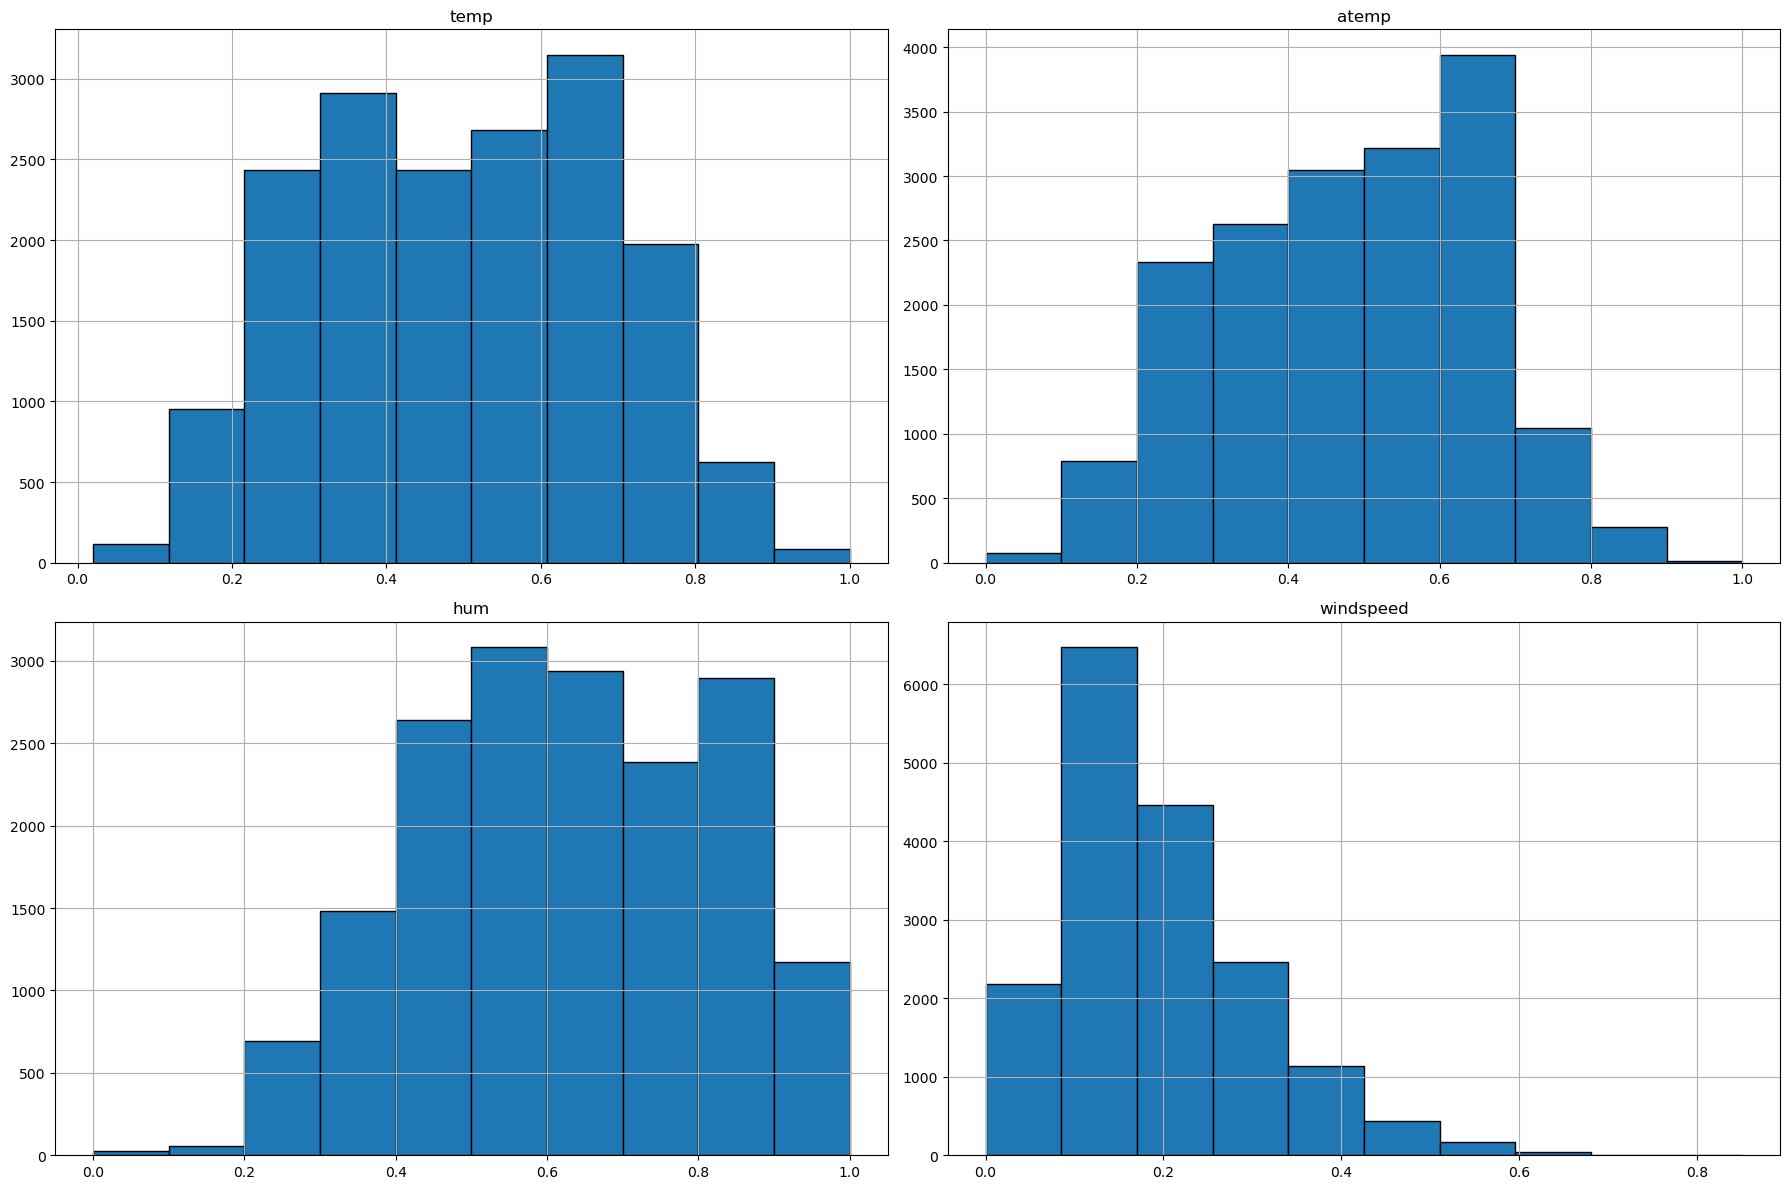

In [ ]:
df.select_dtypes(include='float64').hist(edgecolor='k',figsize=(18,12))

plt.tight_layout();

From the plots, temp and atemp are normally distributed and humidity and windspeed look left and right-skewed.

So using mean value to impute the missing values of temp and atemp and median value to impute the missing values of humidity and windspeed.

In [ ]:
df[['temp','atemp']] = df[['temp','atemp']].fillna(df[['temp','atemp']].mean())

In [ ]:
df[['hum','windspeed']] = df[['hum','windspeed']].fillna(df[['hum','windspeed']].median())

Impute missing values of categorical columns with mode

In [ ]:
cols = ['season','workingday','weathersit','yr','mnth','holiday']
df[cols] = df[cols].fillna(df.mode().iloc[0])

In [ ]:
df.isna().sum().sum()

0

# Data Visualization

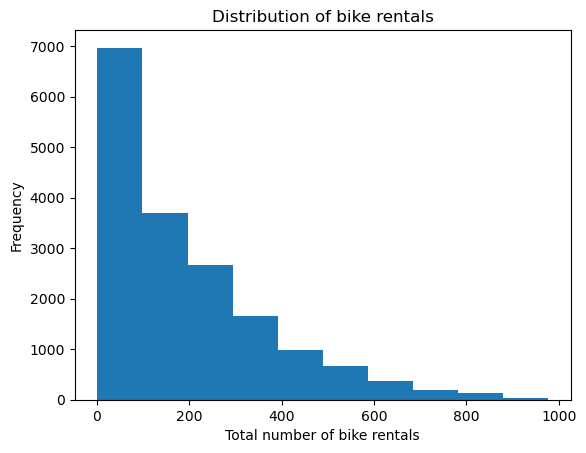

In [ ]:
plt.hist(df['cnt'])
plt.xlabel('Total number of bike rentals')
plt.ylabel('Frequency')
plt.title('Distribution of bike rentals')
plt.show()

## Monthly Distribution


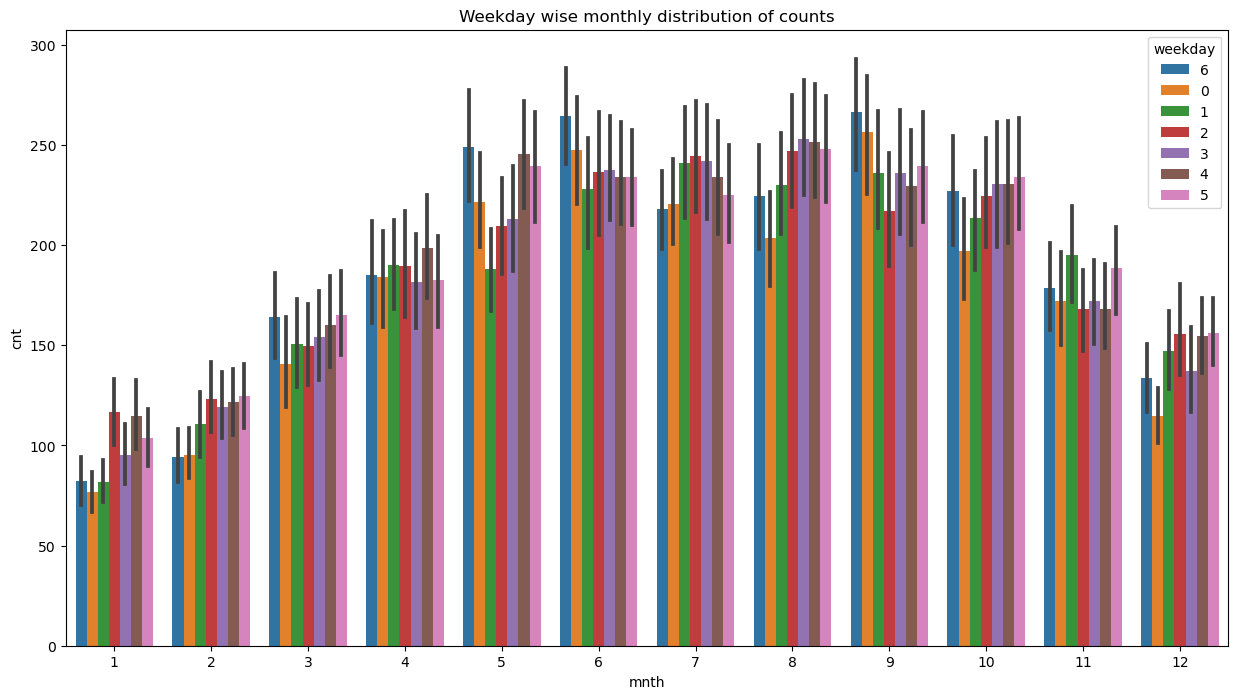

In [ ]:

#plotting bar plots for weekday wise monthly distribution
fig,ax=plt.subplots(figsize=(15,8))
sns.barplot(x='mnth',y='cnt',data=df[['mnth','cnt','weekday']],hue='weekday',ax=ax)
ax.set_title('Weekday wise monthly distribution of counts')
plt.show()

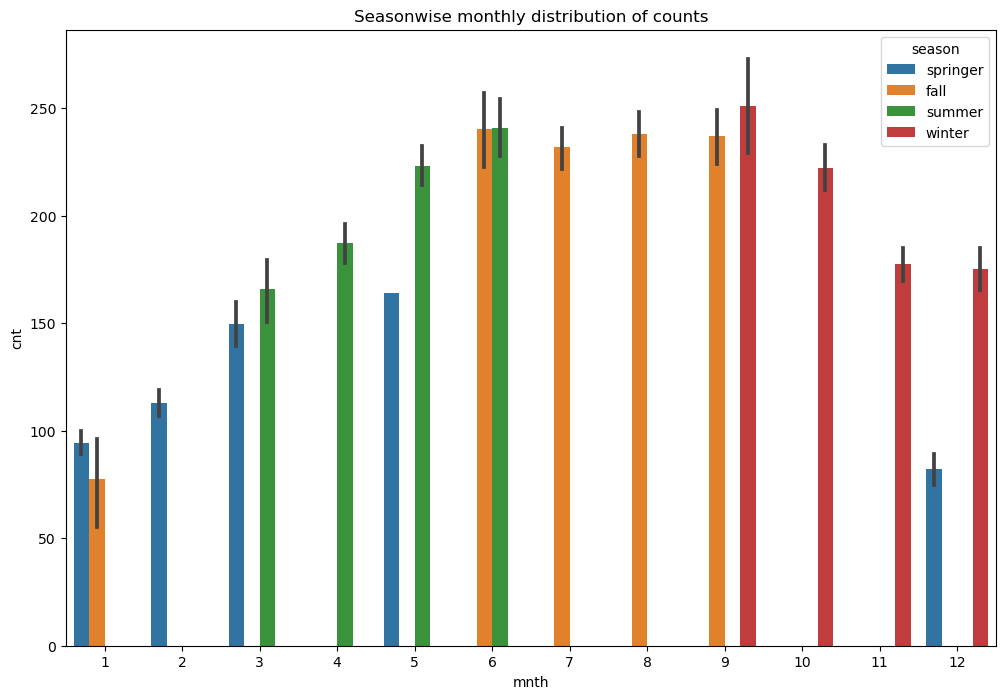

In [ ]:
##plotting bar plots for seasonal wise monthly distribution
fig,ax1=plt.subplots(figsize=(12,8))
sns.barplot(x='mnth',y='cnt',data=df[['mnth','cnt','season']],hue='season',ax=ax1)
ax1.set_title('Seasonwise monthly distribution of counts')
plt.show()

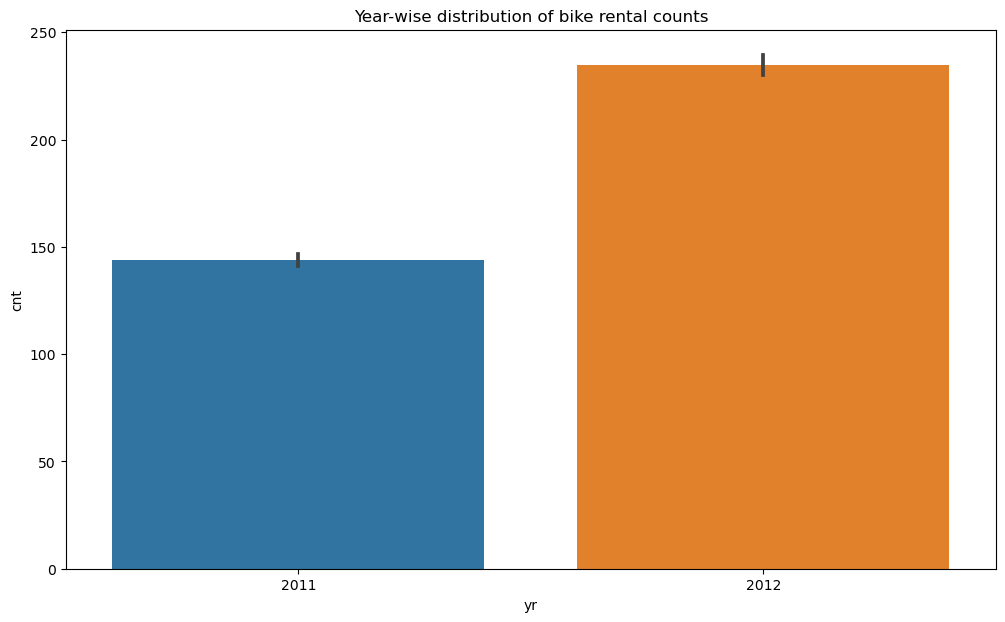

In [ ]:
#Yearly distribution
fig, ax2 = plt.subplots(figsize=(12,7))
sns.barplot(x='yr', y='cnt', data=df)
ax2.set_title('Year-wise distribution of bike rental counts')
plt.show()

#### **Working day wise distribution of count**


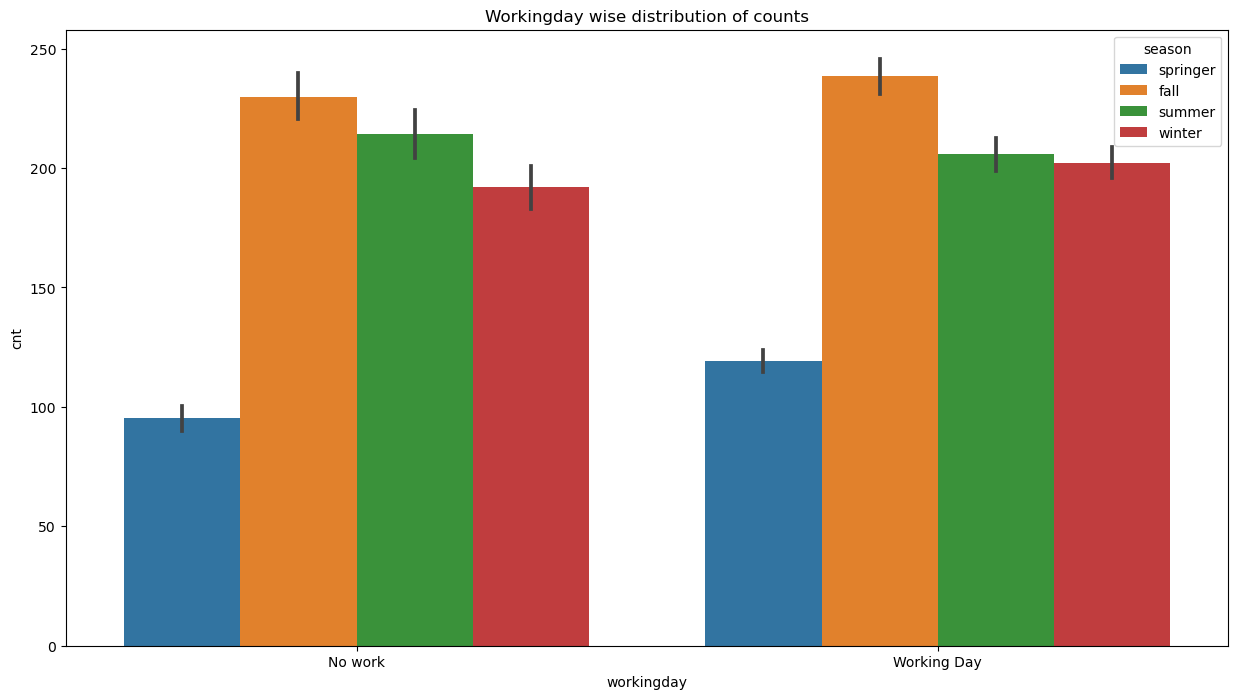

In [ ]:
fig,ax3=plt.subplots(figsize=(15,8))
#Bar plot for workingday distribution of counts
sns.barplot(data=df,x='workingday',y='cnt',hue='season')
ax3.set_title('Workingday wise distribution of counts')
plt.show()

#### **Holiday wise distribution**

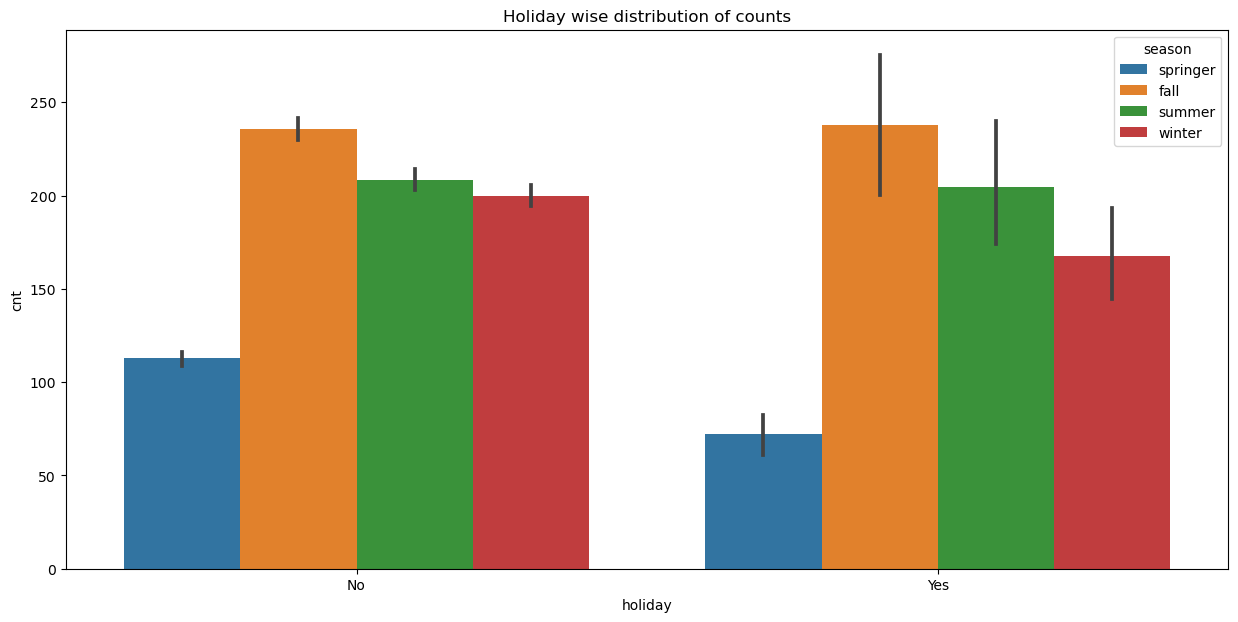

In [ ]:
fig,ax4=plt.subplots(figsize=(15,7))
#Barplot for Holiday distribution of counts
sns.barplot(data=df,x='holiday',y='cnt',hue='season')
ax4.set_title('Holiday wise distribution of counts')
plt.show()

#### **Weather wise distribution**


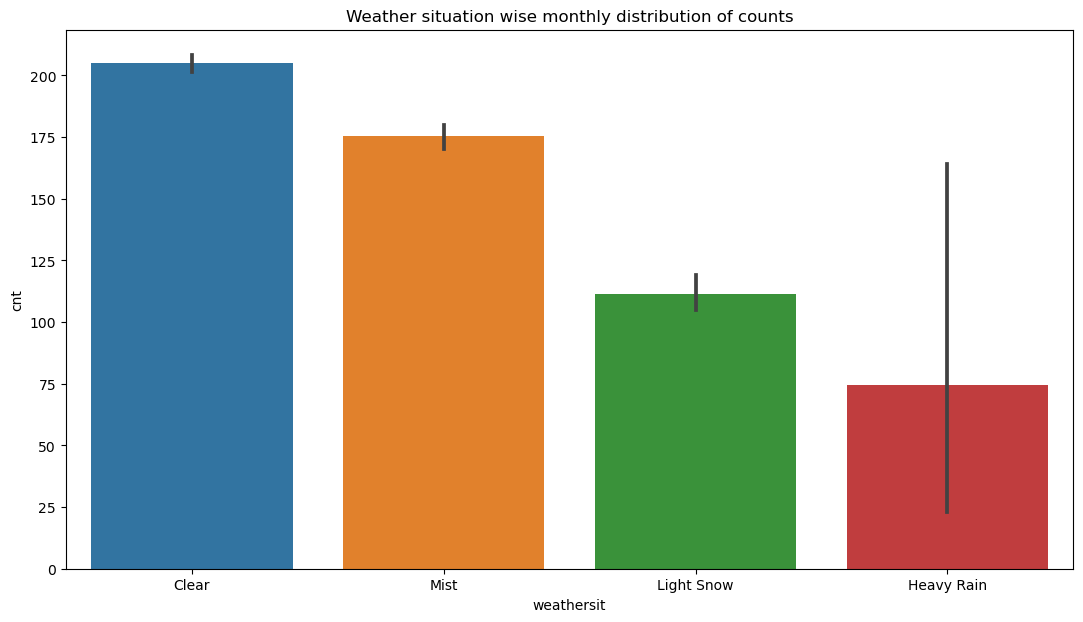

In [ ]:
fig,ax5=plt.subplots(figsize=(13,7))
#Bar plot for weather_condition distribution of counts
sns.barplot(x='weathersit',y='cnt',data=df[['mnth','cnt','weathersit']],ax=ax5)
ax5.set_title('Weather situation wise monthly distribution of counts')
plt.show()

### Check for Outliers :
Box plot :

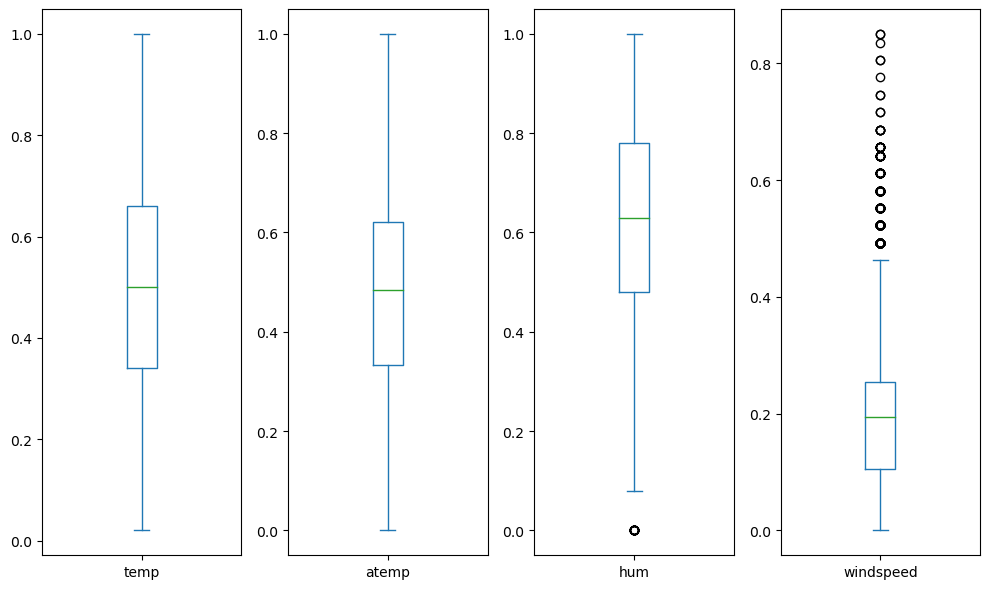

In [ ]:
df.select_dtypes(include='float64').plot(kind='box',subplots=True,figsize=(10,6))
plt.tight_layout();

There is one outlier on the humidity column on the lower side and a few a outliers on the windspeed column on the higher side.



[Text(0.5, 0, 'workingday'),
 Text(0, 0.5, 'cnt'),
 Text(0.5, 1.0, 'Boxplot for count vs workingday')]

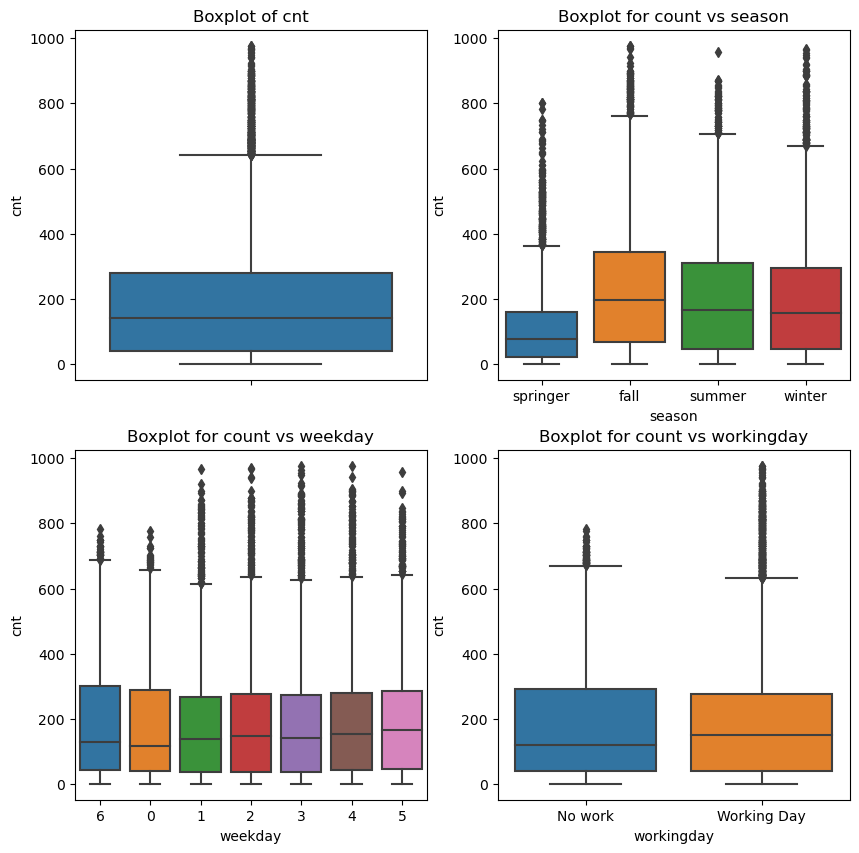

In [ ]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(10,10)
sns.boxplot(data=df,y="cnt",orient='v',ax=axes[0][0])
sns.boxplot(data=df,y="cnt",x="season",orient='v',ax=axes[0][1])
sns.boxplot(data=df,y="cnt",x="weekday",orient="v",ax=axes[1][0])
sns.boxplot(data=df,y="cnt",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='cnt',title = "Boxplot of cnt")
axes[0][1].set(xlabel="season",ylabel="cnt",title="Boxplot for count vs season")
axes[1][0].set(xlabel="weekday", ylabel="cnt",title="Boxplot for count vs weekday")
axes[1][1].set(xlabel="workingday",ylabel="cnt",title="Boxplot for count vs workingday")

The boxplot helps in detecting the outliners in the particuar attribute. The above graph clearly says that there are outliners in cnt , season , weekday and working day columns.

# Replace the outliers

Capping is commonly used to handle outliers in a dataset. Outliers are extreme values that are much larger or smaller than the majority of the data points in a distribution. Outliers can be caused by measurement errors, data entry errors, or other factors, and can distort statistical analyses and machine learning models.



In [ ]:
# define function to cap outliers
def cap_outliers(column):
    Q1 = np.percentile(column, 25)
    Q3 = np.percentile(column, 75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5*IQR
    lower_bound = Q1 - 1.5*IQR
    capped_column = np.clip(column, lower_bound, upper_bound)
    return capped_column

# select columns to cap outliers
cols_to_cap = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
# cap outliers for selected columns
for col in cols_to_cap:
    df[col] = cap_outliers(df[col])

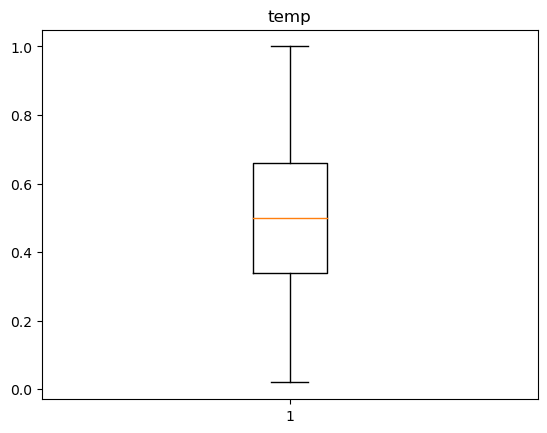

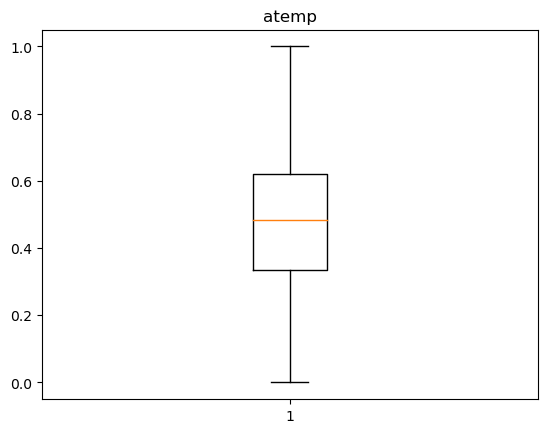

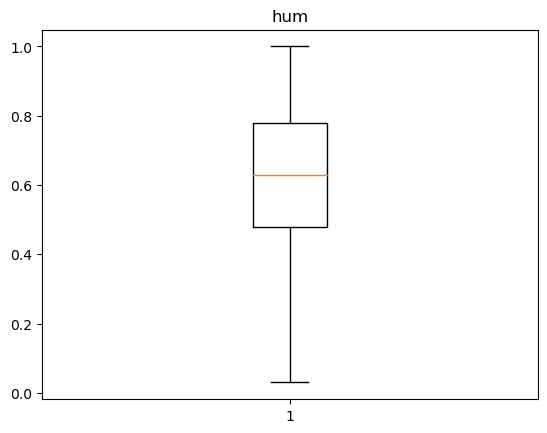

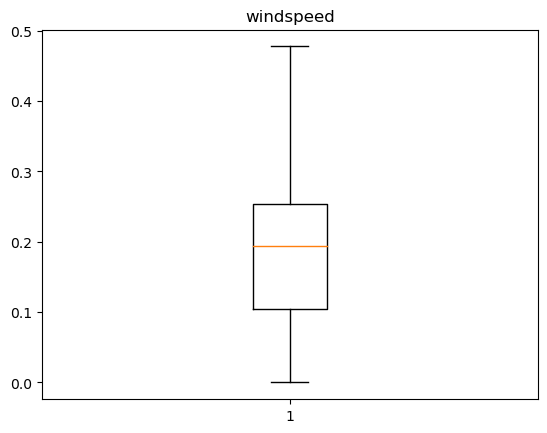

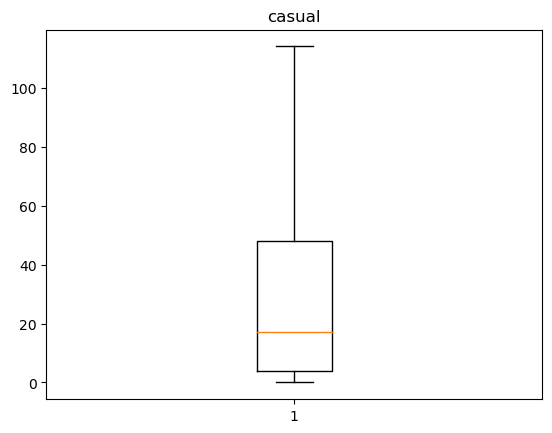

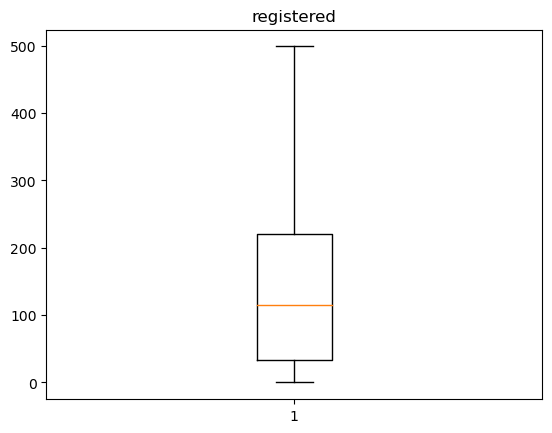

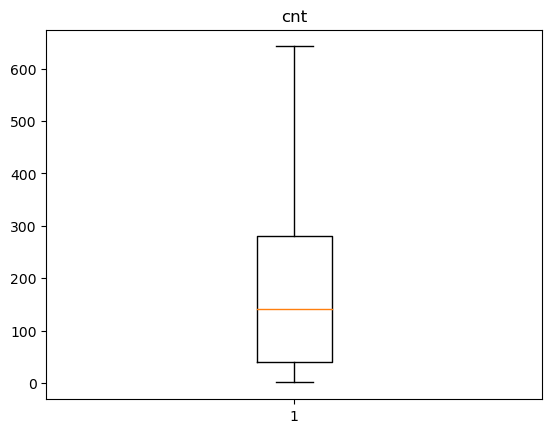

In [ ]:
#Data visualization after replacing outliers
fig.set_size_inches(10,10)
for col in cols_to_cap:
    plt.boxplot(df[col])
    plt.title(col)
    plt.show()

# Bivariate analysis :


# # # Scatter plot :

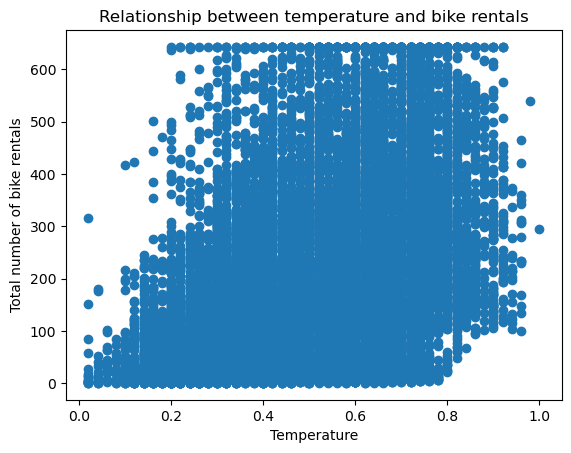

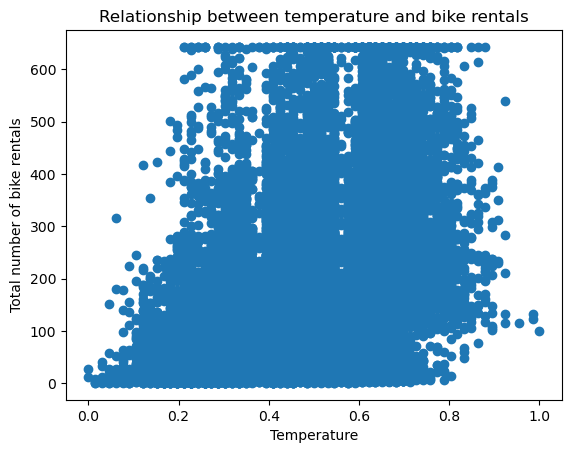

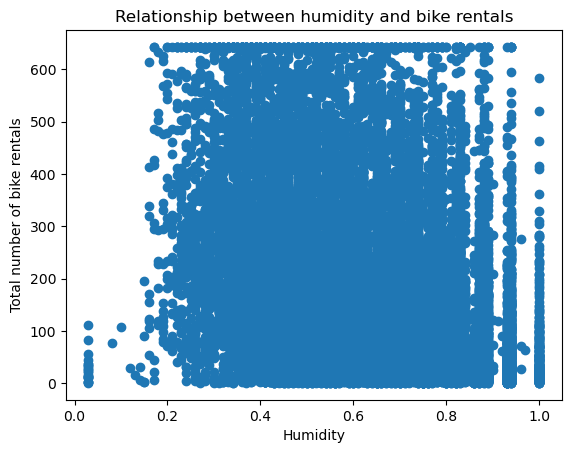

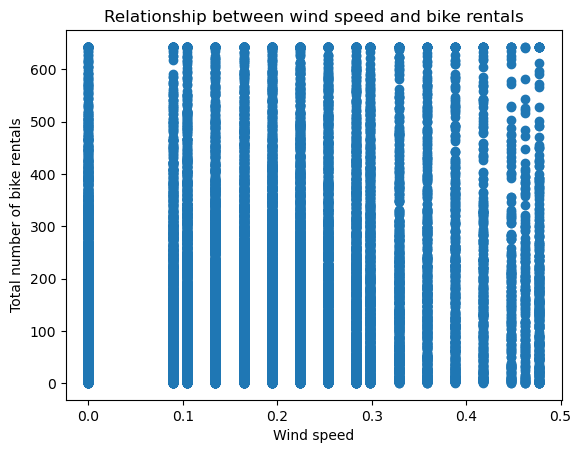

In [ ]:
#Finding the relationship of weather conditions and count variable
fig.set_size_inches(10,7)
plt.scatter(df['temp'], df['cnt'])
plt.xlabel('Temperature')
plt.ylabel('Total number of bike rentals')
plt.title('Relationship between temperature and bike rentals')
plt.show()

fig.set_size_inches(10,7)
plt.scatter(df['atemp'], df['cnt'])
plt.xlabel('Temperature')
plt.ylabel('Total number of bike rentals')
plt.title('Relationship between temperature and bike rentals')
plt.show()

fig.set_size_inches(10,7)
plt.scatter(df['hum'], df['cnt'])
plt.xlabel('Humidity')
plt.ylabel('Total number of bike rentals')
plt.title('Relationship between humidity and bike rentals')
plt.show()

fig.set_size_inches(10,7)
plt.scatter(df['windspeed'], df['cnt'])
plt.xlabel('Wind speed')
plt.ylabel('Total number of bike rentals')
plt.title('Relationship between wind speed and bike rentals')
plt.show()

From the plots, count and windspeed and count and humidity have no linear relationship. cnt and temp and atemp have slightly linear relationship.

# Pairplot :

<Figure size 2000x2000 with 0 Axes>

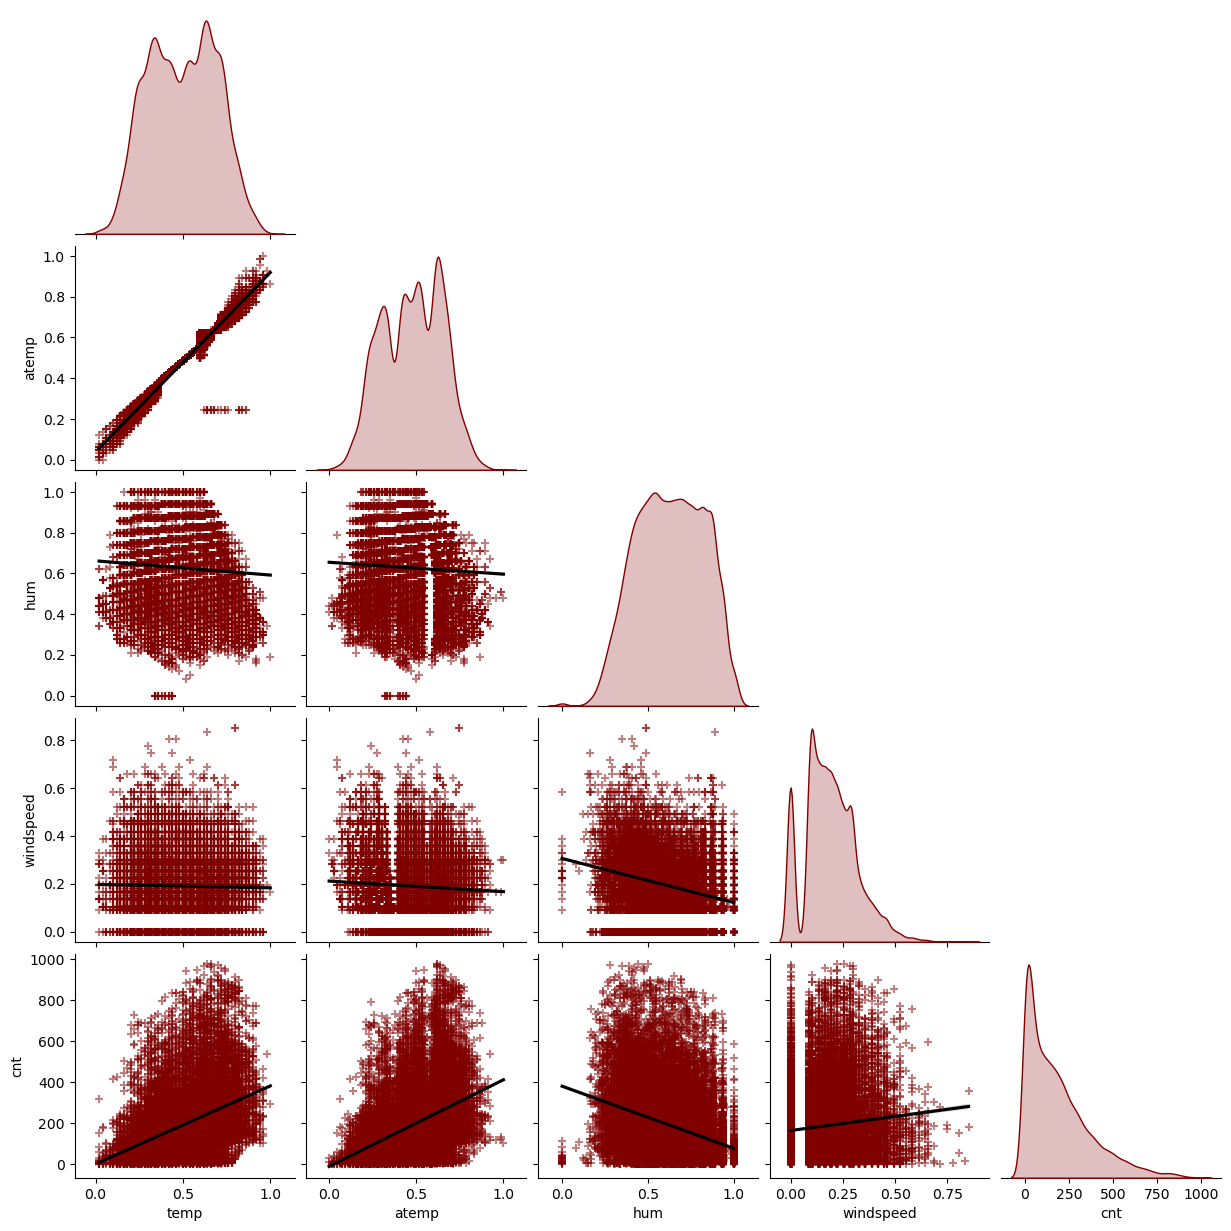

In [ ]:
plt.figure(figsize=(20,20))
sns.pairplot(bike.select_dtypes(include='float64').join(bike['cnt']),markers="+",
                 kind='reg',
                 diag_kind="kde",
                 plot_kws={'line_kws':{'color':'black'},
                           'scatter_kws': {'alpha': 0.5,
                                           'color': 'maroon'}},
               corner=True,
                 diag_kws= {'color': 'maroon'})
plt.show()

<Figure size 1500x3000 with 0 Axes>

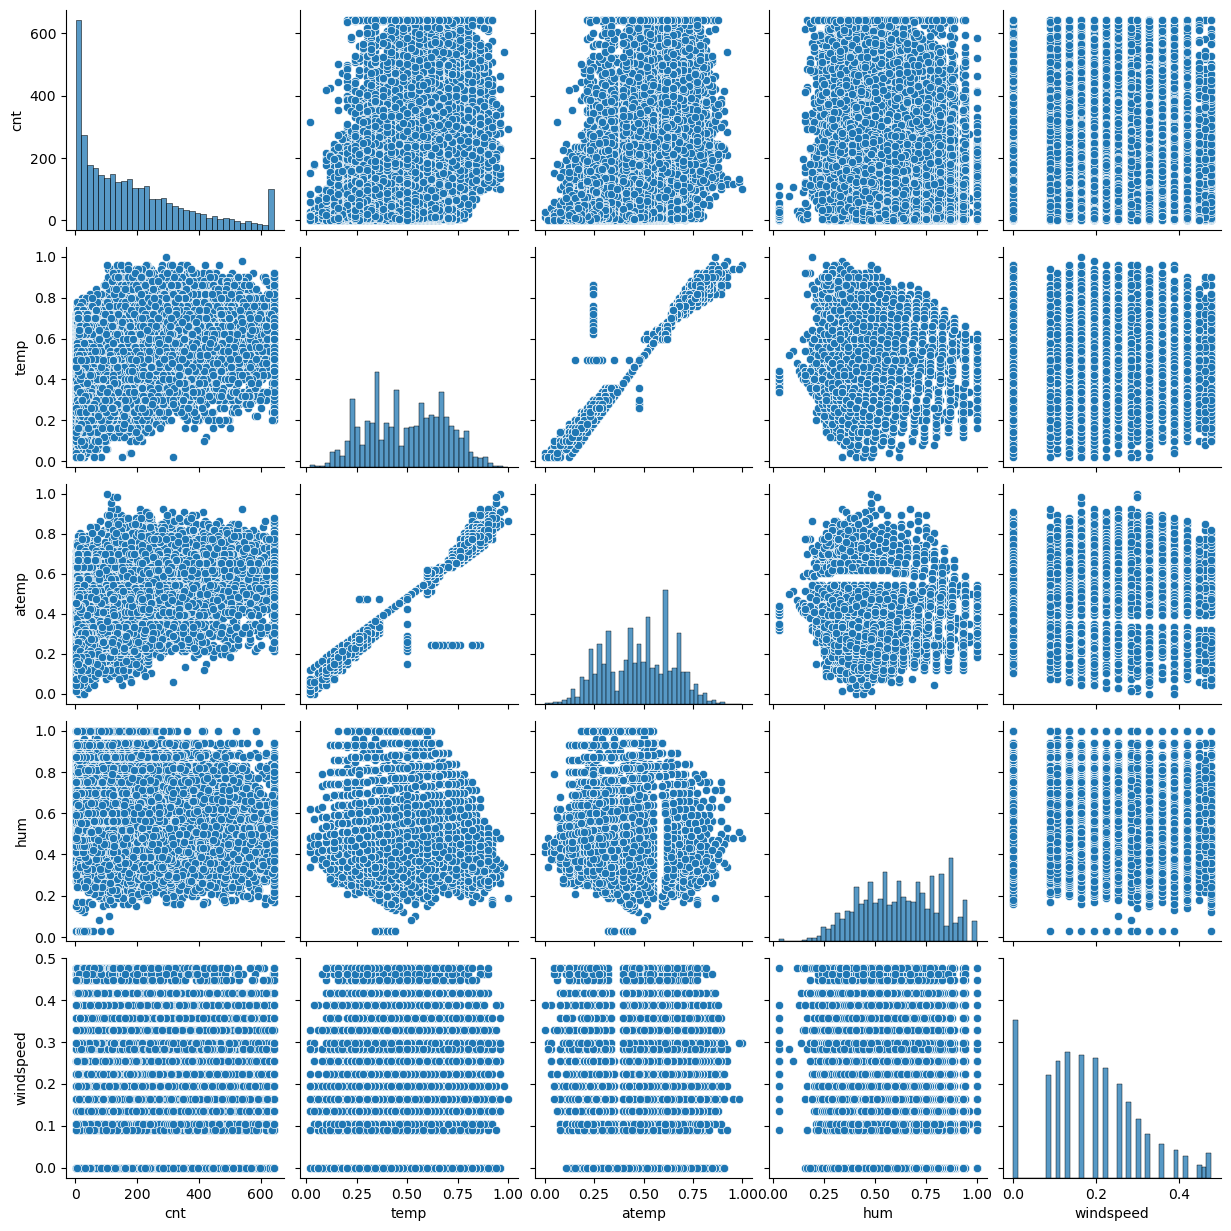

In [ ]:
#Draw pairplots for continuous numeric variables using seaborn
plt.figure(figsize = (15,30))
sns.pairplot(data=df,vars=['cnt', 'temp', 'atemp', 'hum','windspeed'])
plt.show()

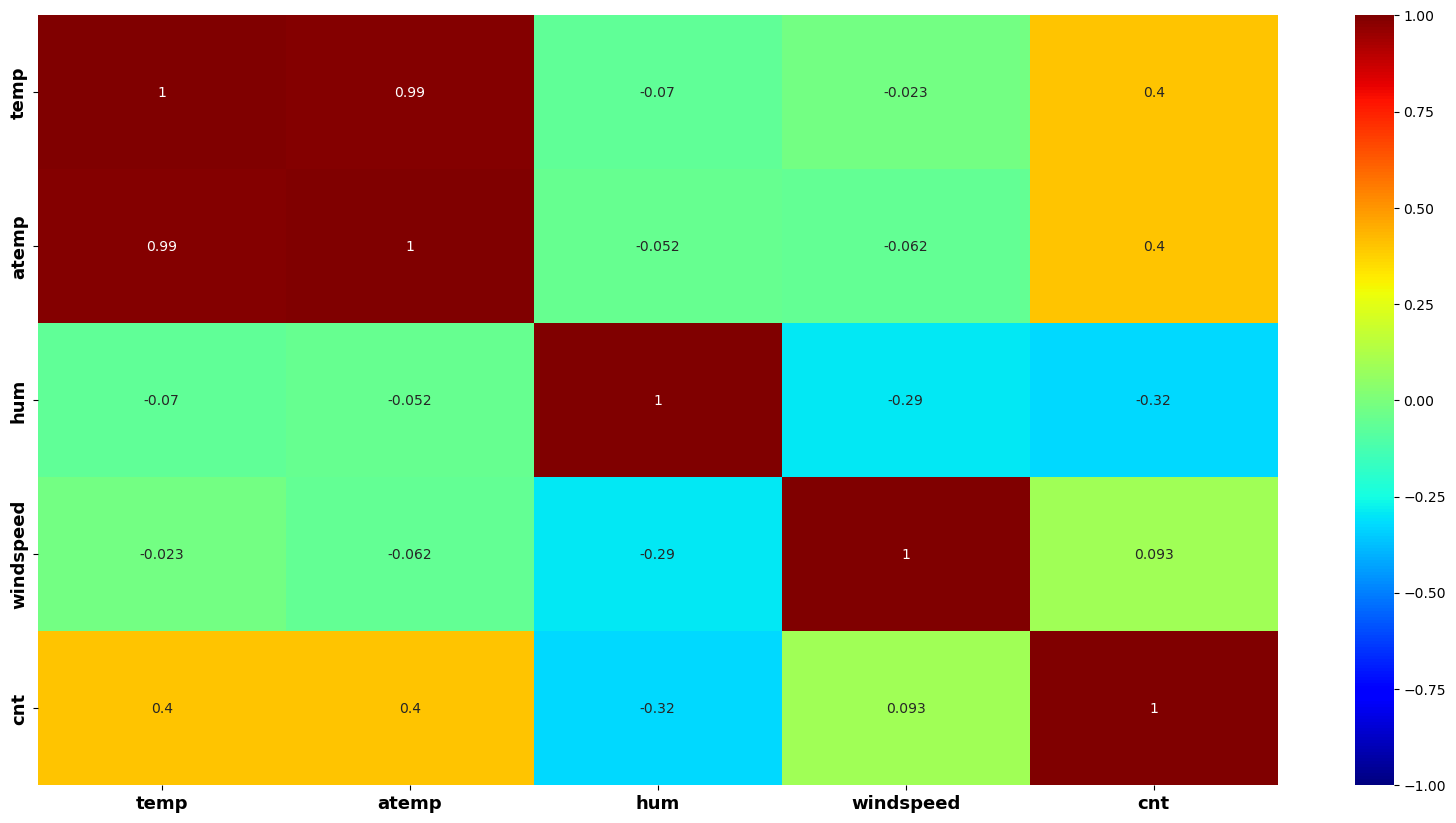

In [ ]:
correlation = bike.select_dtypes(include='float64').join(bike['cnt']).corr()
plt.figure(figsize=(20,10))
ax=sns.heatmap(data=correlation,annot=True,vmax=1,vmin=-1,cmap='jet')
plt.xticks(fontsize=13,fontweight='bold')
plt.yticks(fontsize=13,fontweight='bold');

- Casual and registered contain direct information about the bike sharing count which is to predict (data leakage). Therefore they are not considered in the feature set.
- The variables "temp" and "atemp" are strongly correlated. To reduce the dimensionality of the predictive model, the feature "atemp" is dismissed.And none of the independent variables are strongly correlated with the dependent variable count.

# Check for Multicollinearity :
- can detect high-multi-collinearity by inspecting the eigen values of correlation matrix. A very low eigen value shows that the data are collinear, and the corresponding eigen vector shows which variables are collinear.

- If there is no collinearity in the data, you would expect that none of the eigen values are close to zero

In [ ]:
w, v = np.linalg.eig(correlation)
w

array([2.28513799, 0.01153075, 1.37540505, 0.76986036, 0.55806585])

The 2nd eigen value is close to zero. The corresponding eigen vector is :

In [ ]:
v[:,1]

array([-0.70593566,  0.70774748, -0.00566738,  0.02664602, -0.00249242])

- In the eigen vectors we look for numbers not close to zero. Here the first and second vectors are not close to zero which corresponds to temp and atemp variables. Hence temp are atemp are collinear.


#### <font color='maroon'><b>Point plot :

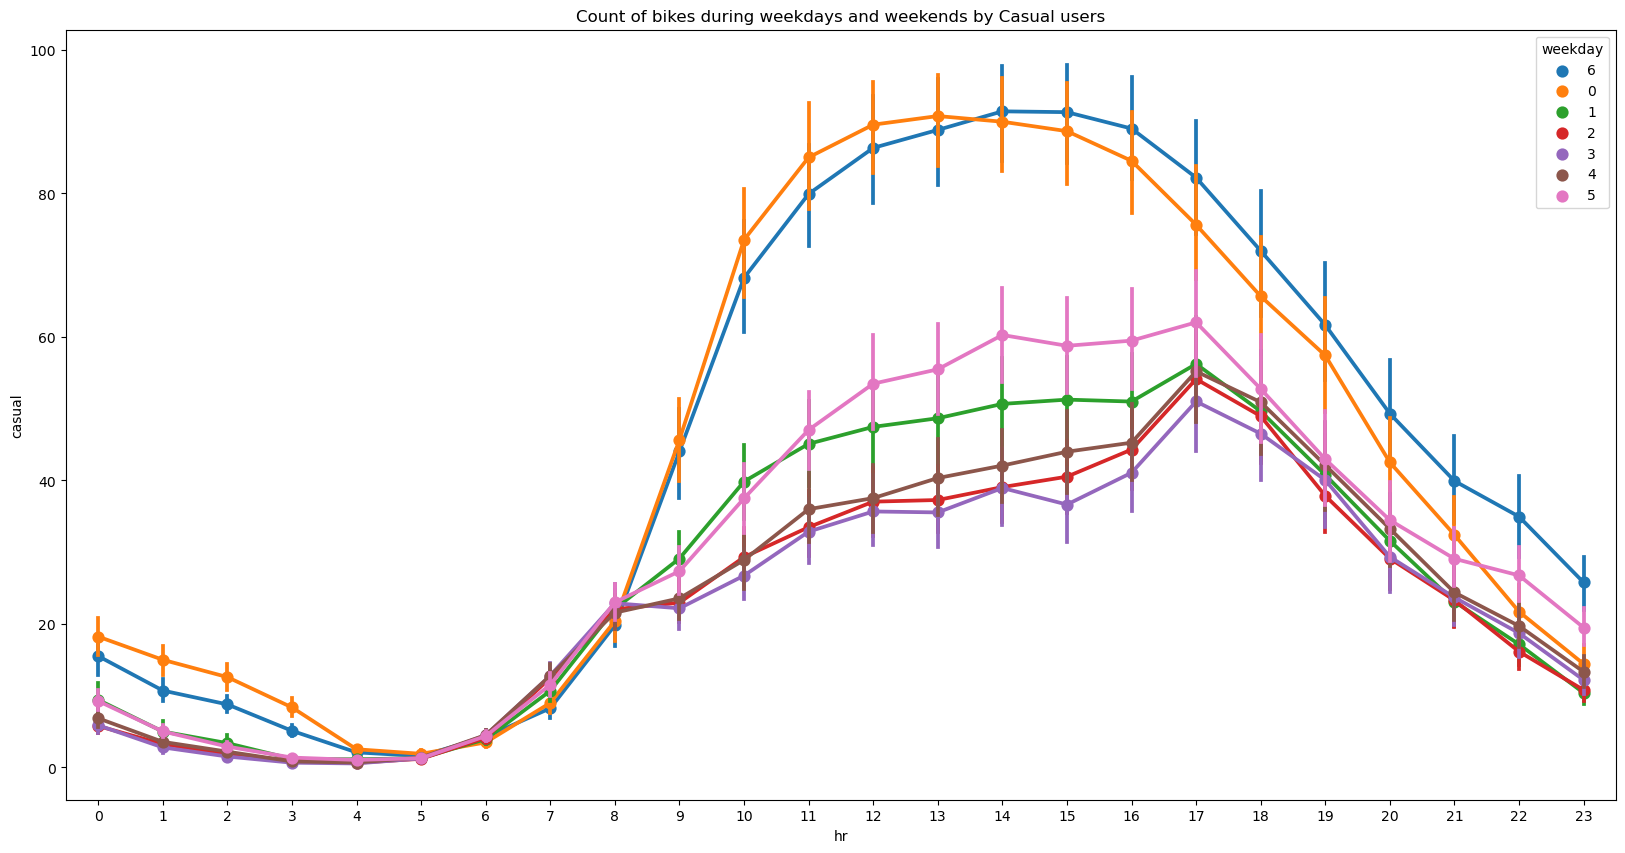

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
sns.pointplot(data=df, x='hr',y='casual', hue='weekday', ax=ax)
ax.set(title='Count of bikes during weekdays and weekends by Casual users');

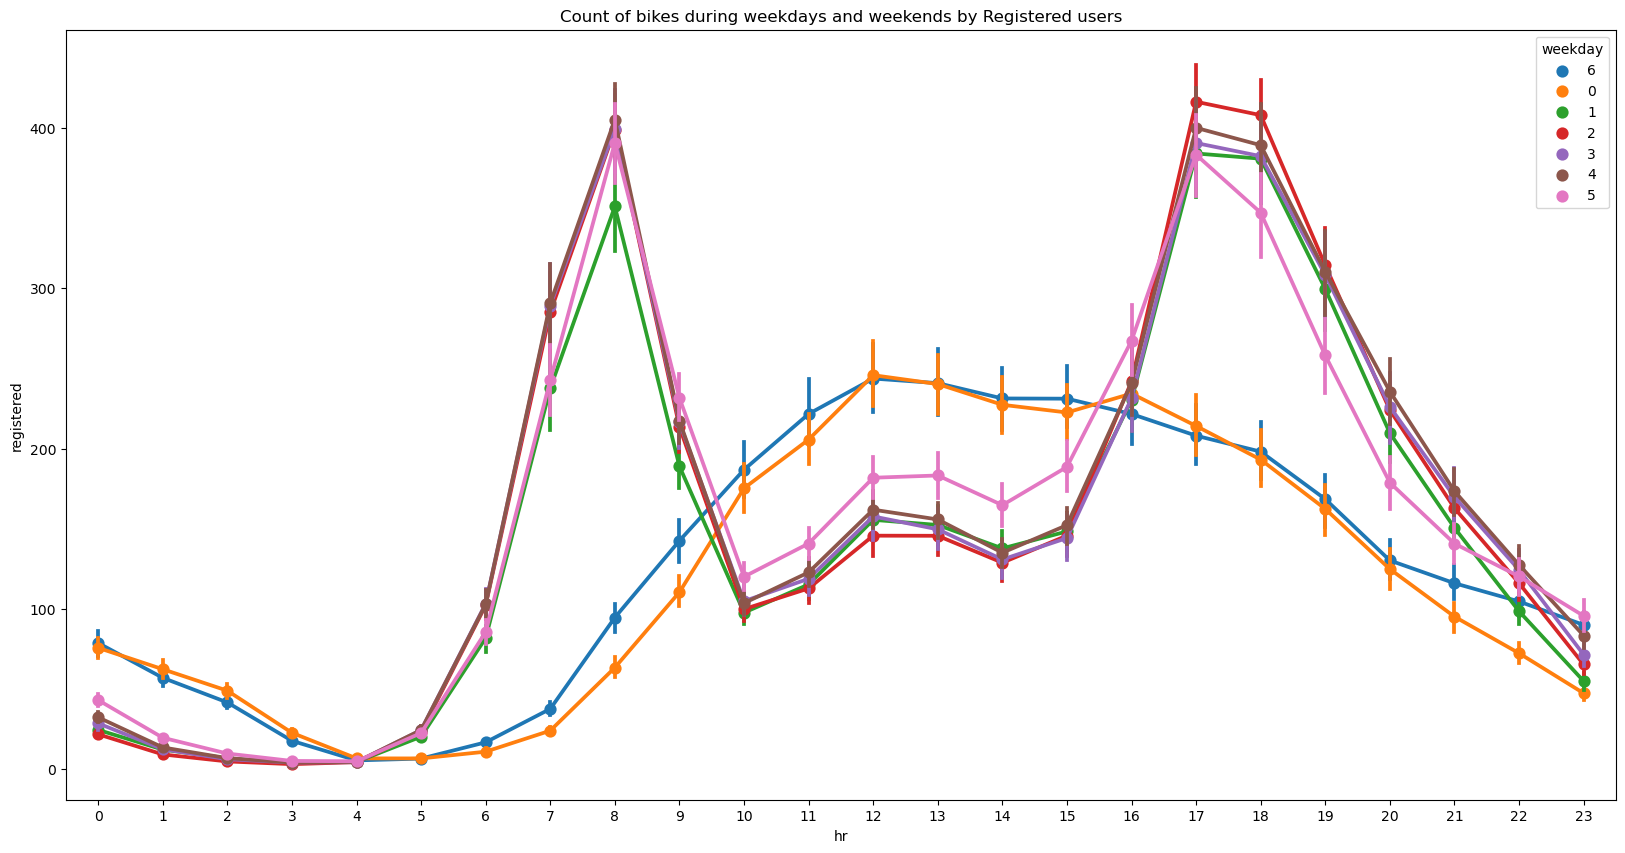

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
sns.pointplot(data=df, x='hr',y='registered', hue='weekday', ax=ax)
ax.set(title='Count of bikes during weekdays and weekends by Registered users');

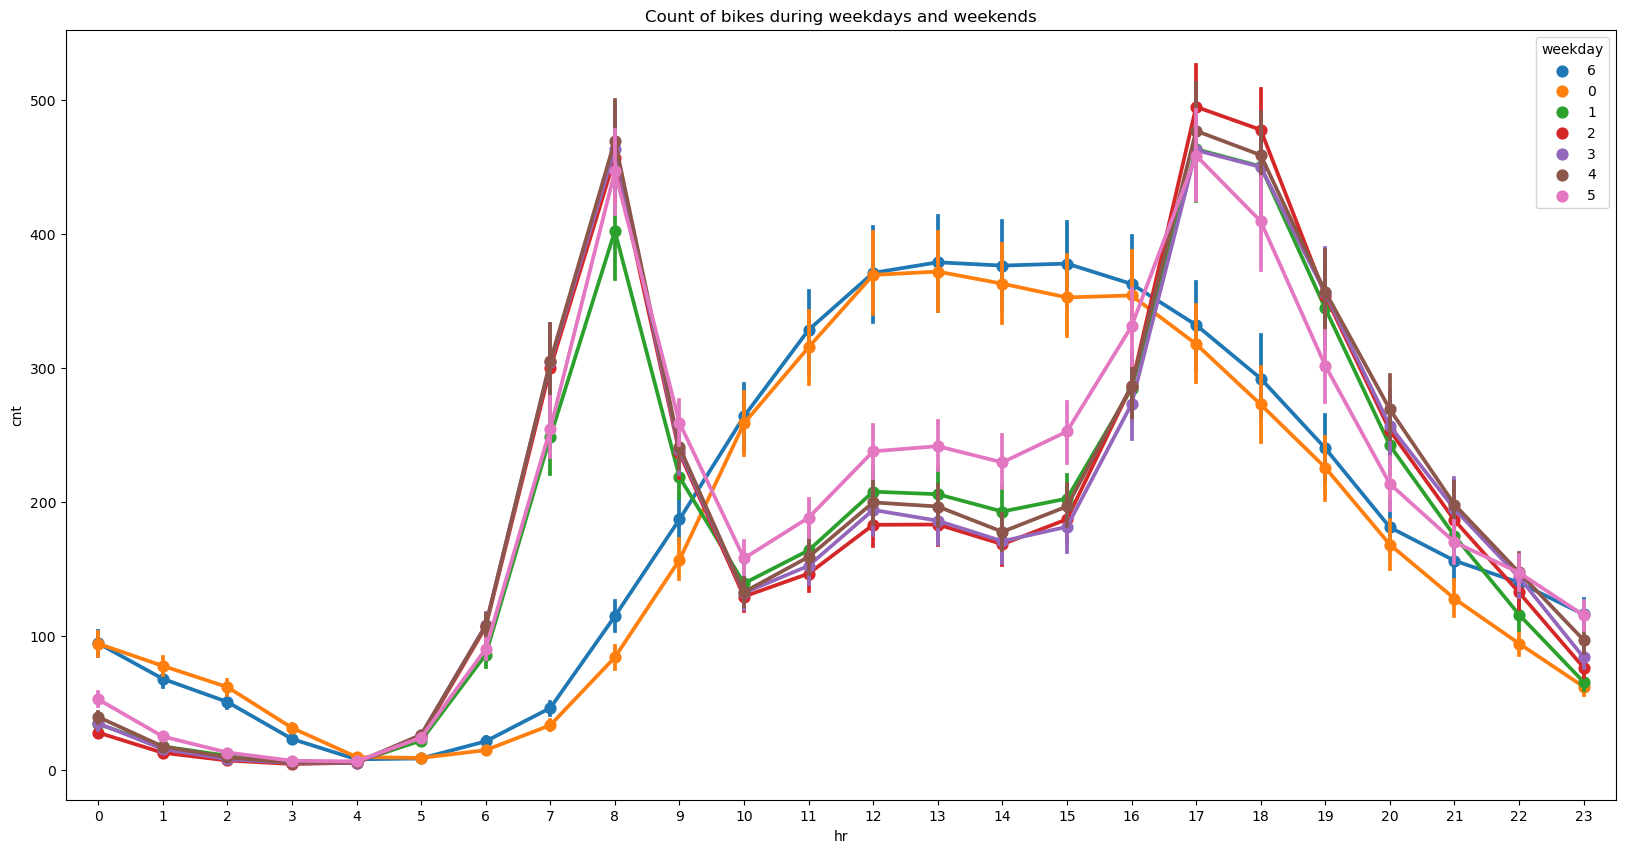

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
sns.pointplot(data=df, x='hr',y='cnt', hue='weekday', ax=ax)
ax.set(title='Count of bikes during weekdays and weekends');

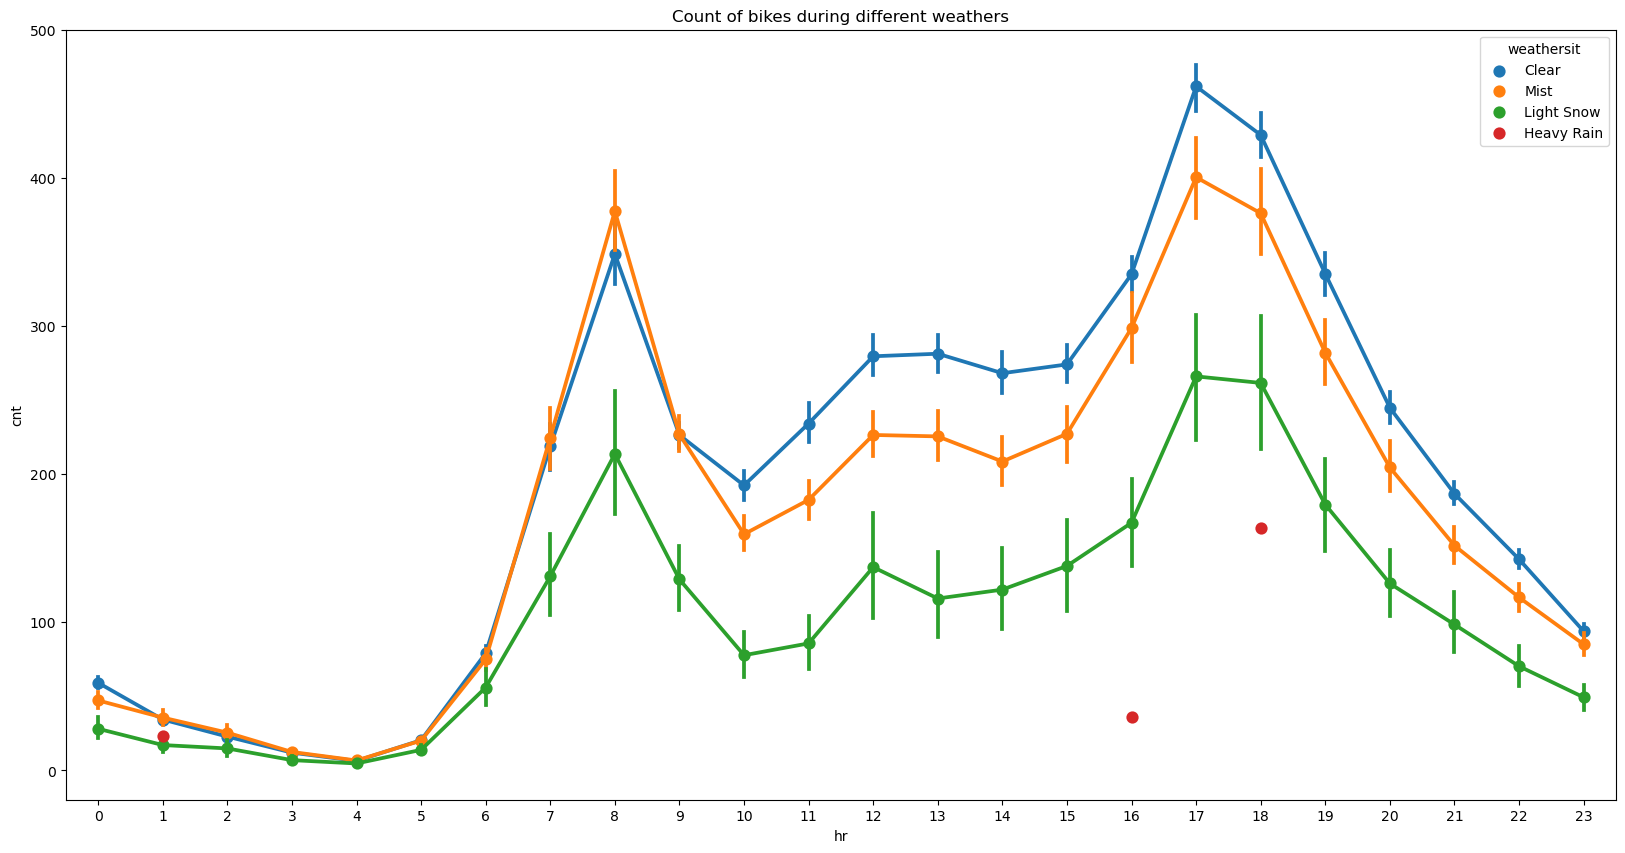

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
sns.pointplot(data=df, x='hr', y='cnt', hue='weathersit', ax=ax)
ax.set(title='Count of bikes during different weathers');

 The two dots are when weather is heavy rain, hence no bookings.

## Feature Scaling
- Feature scaling helps in avoiding the large scale range values dominating the small scale range values. All the variables in our dataset is either categorical or numerical but the temp , windspeed , atemp and hum are continous values and are needed to be normalized in order fit in the scale.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# create a scaler object
scaler = MinMaxScaler()

# select the features to be scaled
features = ['temp', 'atemp', 'hum', 'windspeed']

# fit the scaler object to the selected features
scaler.fit(df[features])

# transform the selected features using the scaler object
df[features] = scaler.transform(df[features])

In [ ]:
df.head(5)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,springer,2011,1,0,No,6,No work,Clear,0.224490,0.2879,0.804124,0.0,3.0,13.0,16.0
1,springer,2011,1,1,No,6,No work,Clear,0.204082,0.2727,0.793814,0.0,8.0,32.0,40.0
2,springer,2011,1,2,No,6,No work,Clear,0.204082,0.2727,0.618557,0.0,5.0,27.0,32.0
3,springer,2011,1,3,No,6,No work,Clear,0.224490,0.2879,0.742268,0.0,3.0,10.0,13.0
4,springer,2011,1,4,No,6,No work,Clear,0.224490,0.2879,0.742268,0.0,0.0,1.0,1.0


In [ ]:
df['season'].replace(['NaN','springer'],[0,1],inplace=True)
df['holiday'].replace(['No','Yes'],[0,1],inplace=True)
df['yr'].replace(['2011','2012'],[0,1],inplace=True)
df['workingday'].replace(['No work','Working Day'],[0,1],inplace=True)
df['weathersit'].replace(['Clear','Mist','Light Snow'],[1,2,3],inplace=True)
df.head(10)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,0,6,0,1,0.224490,0.2879,0.804124,0.000000,3.0,13.0,16.0
1,1,0,1,1,0,6,0,1,0.204082,0.2727,0.793814,0.000000,8.0,32.0,40.0
2,1,0,1,2,0,6,0,1,0.204082,0.2727,0.618557,0.000000,5.0,27.0,32.0
3,1,0,1,3,0,6,0,1,0.224490,0.2879,0.742268,0.000000,3.0,10.0,13.0
4,1,0,1,4,0,6,0,1,0.224490,0.2879,0.742268,0.000000,0.0,1.0,1.0
5,1,0,1,5,0,6,0,2,0.224490,0.2576,0.742268,0.187644,0.0,1.0,1.0
6,1,0,1,6,0,6,0,1,0.204082,0.2727,0.793814,0.000000,2.0,0.0,2.0
7,1,0,1,7,0,6,0,1,0.183673,0.2576,0.855670,0.000000,1.0,2.0,3.0
8,1,0,1,8,0,6,0,1,0.224490,0.2879,0.742268,0.000000,1.0,7.0,8.0
9,1,0,1,9,0,6,0,1,0.486874,0.3485,0.752577,0.000000,8.0,6.0,14.0


In [ ]:

df.drop(['casual','registered'],axis=1,inplace=True)
df.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,0.224490,0.2879,0.804124,0.0,16.0
1,1,0,1,1,0,6,0,1,0.204082,0.2727,0.793814,0.0,40.0
2,1,0,1,2,0,6,0,1,0.204082,0.2727,0.618557,0.0,32.0
3,1,0,1,3,0,6,0,1,0.224490,0.2879,0.742268,0.0,13.0
4,1,0,1,4,0,6,0,1,0.224490,0.2879,0.742268,0.0,1.0


 we will need to apply one-hot encoding to the categorical variables. We will do that by applying the get_dummies function.

In [ ]:
df = pd.get_dummies(df)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('cnt', axis=1), df.cnt, test_size=0.25, random_state=5)

# Linear Regression

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)

# Get the RMSE for the train dataset
print(np.sqrt(mean_squared_error(y_train, reg.predict(X_train))))

# Get the RMSE for the test dataset
print(np.sqrt(mean_squared_error(y_test, reg.predict(X_test))))

94.45064191092439
95.06880488364067


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor().fit(X_train, y_train)

# Get the RMSE for the train dataset
print(np.sqrt(mean_squared_error(y_train, rf.predict(X_train))))

# Get the RMSE for the test dataset
print(np.sqrt(mean_squared_error(y_test, rf.predict(X_test))))

18.02384518093132
48.76541809750452


# Gradient Boost



In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor().fit(X_train, y_train)

# Get the RMSE for the train dataset
print(np.sqrt(mean_squared_error(y_train, gb.predict(X_train))))

# Get the RMSE for the test dataset
print(np.sqrt(mean_squared_error(y_test, gb.predict(X_test))))

77.26899413860494
78.28231351369705


# Choose the Best Model

#### Based on the RMSE on both train and test dataset, the best model is the Random Forest.

# Statistical Analysis

### Based on the statistical analysis and the Gini, we will define the most important variables of the Random Forest model.

In [ ]:
feat_importances = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances

,Importance
atemp,0.166267
workingday,0.087774
hum,0.084387
hr_17,0.071428
yr,0.067809
hr_18,0.066391
hr_8,0.061016
temp,0.056223
hr_19,0.034286
hr_7,0.020126


<AxesSubplot:>

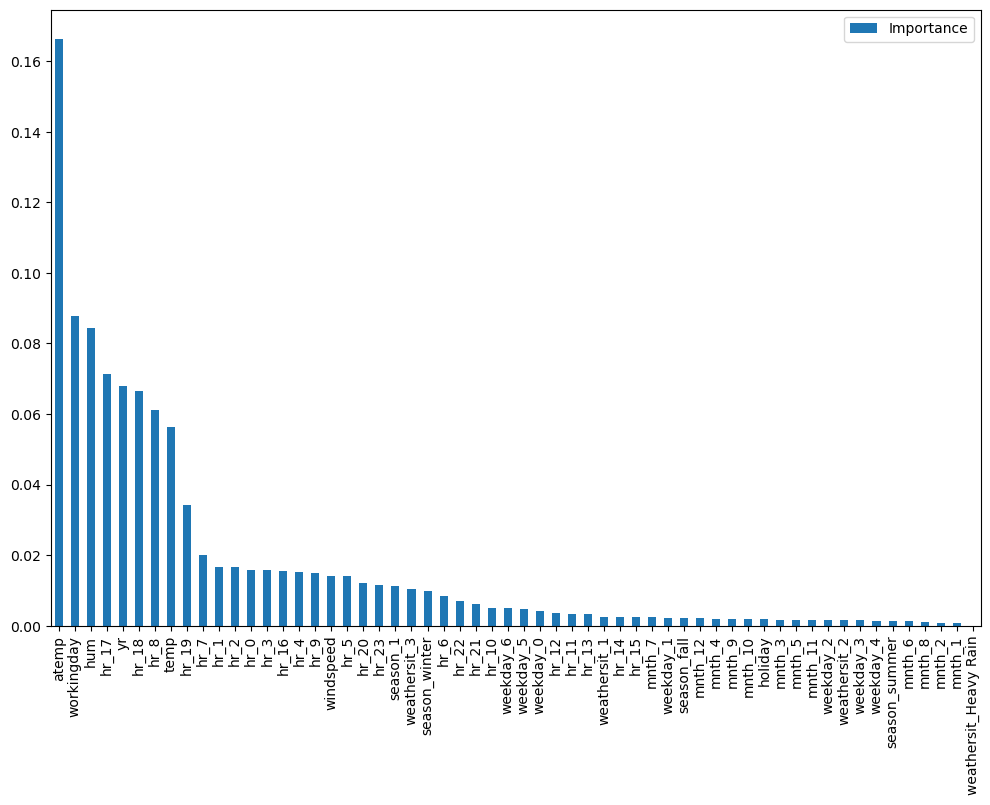

In [ ]:
feat_importances.plot(kind='bar', figsize=(12,8))

As we can see the most important variables are:

- The Hour with 60%
- The Temperature with14%
- The Year with 8%

# Insights
- We found that the number of Bike Rentals depends on the hour and the temperature. Also, it seems that there is an interaction between variables, like hour and day of week, or month and year etc and for that reason, the tree-based models like Gradient Boost and Random Forest performed much better than the linear regression. Moreover, the tree-based models are able to capture nonlinear relationships, so for example, the hours and the temperature do not have a linear relationship, so for example, if it is extremely hot or cold then the bike rentals can drop. Our model has an RMSE of 42 in the test dataset which seems to be promising.

# Further Analysis
There is always a room of improvement when we build Machine Learning models. For instance we could try the following:

- Transform the cnt column to the logarith of cnt
- Try different models using Grid Search
- Fine tuning of the Hyperparameters of the model

# Export the Predictions


In [ ]:
# the name of my model is rf - this is how I called it before

# now I re-train my model on the whole dataset
rf = RandomForestRegressor().fit(df.drop('cnt', axis=1), df.cnt)

# I get the predictions
df['Predictions'] = rf.predict(df.drop('cnt', axis=1))

df.to_csv("my_analysis.csv", index=False)